# Demo
##### This is a demo for testing and training iRestNet. Please refer to README for more information about installation and files organization.
##### Kindly report any suggestions or corrections to the corresponding author.
##### @author: Marie-Caroline Corbineau (mariecaroline.corbineau@gmail.com)

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy.io as sio
import time
from Model_files.iRestNet import iRestNet_class
from Model_files.tools import compute_ssim_results, create_testset, switch_test_config, my_compare_ssim

## 1- Test saved models
### 1.1- Test conditions

In [2]:
dataset         = 'Flickr30'  # choose the test set from {'BSD500','Flickr30'}
config          = 'GaussianC' # choose the blur kernel from {'GaussianA','GaussianB','GaussianC','MotionA','MotionB','Square'}
name_kernel, name_std, noise_std_range = switch_test_config(config) 
im_size         = (256,256)
im_range        = [0,1]       # minimal and maximal pixel values
test_conditions = [name_kernel, name_std, noise_std_range, im_size, im_range]

# Path to the test set and to the folder with the saved model
path_testset       = 'Datasets/Testsets'
path_trainset      = ''
path_save          = os.path.join('Trainings',name_kernel+name_std,'saved_model')
paths              = [path_testset,path_trainset,path_save]

print('--------------------------------------------------------------------------------------------------------------------------------')
print('Configuration: %s'%(config))
print('Testset:       %s'%(dataset))
print('--------------------------------------------------------------------------------------------------------------------------------')

--------------------------------------------------------------------------------------------------------------------------------
Configuration: GaussianC
Testset:       Flickr30
--------------------------------------------------------------------------------------------------------------------------------


### 1.2- Create blurred test images
##### To get the exact same test sets as the ones used in https://arxiv.org/abs/1812.04276 (with the same noise realizations) please contact the authors.

In [3]:
size_testset = len([n for n in os.listdir(os.path.join('Datasets/Groundtruth/full',dataset))]) # number of test images
print('--------------------------------------------------------------------------------------------------------------------------------',flush=True)
print('Creating %d blurred test images from %s using configuration %s...'%(size_testset,dataset,config),flush=True)
create_testset(dataset,'Datasets/Groundtruth',path_testset,name_kernel,name_std,noise_std_range,im_size)
print('--------------------------------------------------------------------------------------------------------------------------------',flush=True)

--------------------------------------------------------------------------------------------------------------------------------
Creating 30 blurred test images from Flickr30 using configuration GaussianC...
100%|██████████| 30/30 [00:01<00:00, 27.39it/s]
--------------------------------------------------------------------------------------------------------------------------------


### 1.3- Hyperparameters setting
##### Choose 'yes' to save the hyperparameters values (stepsize, barrier parameter, regularization parameter), 'no' else.

In [4]:
save_gamma_mu_lambda = 'no' 
print('--------------------------------------------------------------------------------------------------------------------------------',flush=True)
if save_gamma_mu_lambda == 'yes':
    # if save_gamma_mu_lambda == 'yes' then the hyperparameters are saved for each test images in 
    # Trainings/'test configuration'/saved_model/Results_on_Testsets/'test set'/gamma_mu_lambda
    save_gamma_mu_lambda = os.path.join(path_save,'Results_on_Testsets',dataset,'gamma_mu_lambda')
    if not os.path.exists(save_gamma_mu_lambda):
        os.makedirs(save_gamma_mu_lambda)
    print('The stepsize, barrier parameter and regularization parameter will be saved for each layer at location \n%s'%(save_gamma_mu_lambda))
else:
    print('The stepsize, barrier parameter and regularization parameter will not be saved') 
print('--------------------------------------------------------------------------------------------------------------------------------',flush=True)

--------------------------------------------------------------------------------------------------------------------------------
The stepsize, barrier parameter and regularization parameter will not be saved
--------------------------------------------------------------------------------------------------------------------------------


### 1.4- Load a model

In [5]:
network              = iRestNet_class(test_conditions, paths, mode='test')
path_layers          = os.path.join(path_save,'trained_model_MinLossOnVal.pt')
path_post_processing = os.path.join(path_save,'trained_post-processing_MinLossOnVal.pt')
network.model.load_state_dict(torch.load(path_layers))
network.last_layer.load_state_dict(torch.load(path_post_processing))
print('--------------------------------------------------------------------------------------------------------------------------------',flush=True)
print('Loaded proximal interior point layers from %s.'%(path_layers))
print('Loaded the post-processing layer from %s.'%(path_post_processing))
print('--------------------------------------------------------------------------------------------------------------------------------',flush=True)

--------------------------------------------------------------------------------------------------------------------------------
Loaded proximal interior point layers from Trainings/gaussian_3_std_004/saved_model/trained_model_MinLossOnVal.pt.
Loaded the post-processing layer from Trainings/gaussian_3_std_004/saved_model/trained_post-processing_MinLossOnVal.pt.
--------------------------------------------------------------------------------------------------------------------------------


### 1.5- Test a model

In [6]:
print('--------------------------------------------------------------------------------------------------------------------------------',flush=True)
print('Testing model %s ...'%(path_save),flush=True)
time_start = time.time()
network.test(dataset,save_gamma_mu_lambda)
time_per_image = (time.time()-time_start)/size_testset
print('Average time per image: %.2f seconds'%(time_per_image),flush=True)
print('--------------------------------------------------------------------------------------------------------------------------------',flush=True)

--------------------------------------------------------------------------------------------------------------------------------
Testing model Trainings/gaussian_3_std_004/saved_model ...
Saving restaured images in Trainings/gaussian_3_std_004/saved_model/Results_on_Testsets/Flickr30 ...
100%|██████████| 30/30 [01:01<00:00,  2.05s/it]
Average time per image: 2.05 seconds
--------------------------------------------------------------------------------------------------------------------------------


### 1.6- Evaluate the results

In [7]:
print('--------------------------------------------------------------------------------------------------------------------------------',flush=True)
print('Evaluating the results...',flush=True)
ssim_blurred, ssim_restaured = compute_ssim_results(config,dataset,os.path.join(path_save,'Results_on_Testsets',dataset))
print('Average SSIM: blurred images:   %.3f\n              restaured images: %.3f'%(ssim_blurred,ssim_restaured),flush=True)
print('--------------------------------------------------------------------------------------------------------------------------------',flush=True)

--------------------------------------------------------------------------------------------------------------------------------
Evaluating the results...
Average SSIM: blurred images:   0.354
              restaured images: 0.696
--------------------------------------------------------------------------------------------------------------------------------


### 1.7- Visualization

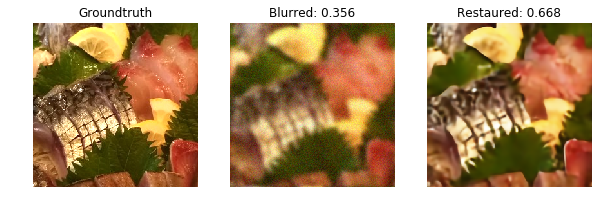

In [8]:
# choose an image 
im_name = '1'
#
path_im_groundtruth = os.path.join('Datasets/Groundtruth/cropped',dataset,im_name+'.mat')
path_im_blurred    = os.path.join(path_testset,name_kernel+name_std,dataset,im_name+'.mat')
path_im_restaured  = os.path.join(path_save,'Results_on_Testsets',dataset,im_name+'.mat')
#
im_groundtruth = sio.loadmat(path_im_groundtruth)['image']
im_blurred     = sio.loadmat(path_im_blurred)['image']
im_restaured   = sio.loadmat(path_im_restaured)['image']
# plot
plt.figure(1,figsize=(10, 10))
#
plt.subplot(131)
plt.imshow(im_groundtruth)
plt.axis('off')
plt.title('Groundtruth')
#
plt.subplot(132)
plt.imshow(np.clip(im_blurred,0,1))
plt.axis('off')
plt.title('Blurred: %.3f'%(my_compare_ssim(im_groundtruth,im_blurred)))
#
plt.subplot(133)
plt.imshow(im_restaured)
plt.axis('off')
plt.title('Restaured: %.3f'%(my_compare_ssim(im_groundtruth,im_restaured)))
#
plt.show()

## 2- Train a model
### 2.1- Training conditions

In [9]:
config          = 'GaussianC' # choose the blur kernel from {'GaussianA','GaussianB','GaussianC','MotionA','MotionB','Square'}
name_kernel, name_std, noise_std_range = switch_test_config(config) 
im_size         = (256,256)
im_range        = [0,1]       # minimal and maximal pixel values
test_conditions = [name_kernel, name_std, noise_std_range, im_size, im_range]

# path to training set and save folder
path_testset       = 'Datasets/Testsets'
path_trainset      = os.path.join('Datasets','BSD500_COCO1000_train_val')
path_save          = os.path.join('Trainings',name_kernel+name_std,'MyTraining')
paths              = [path_testset,path_trainset,path_save]

if not os.path.exists(path_save):
            os.makedirs(path_save)

print('--------------------------------------------------------------------------------------------------------------------------------')
print('Configuration: %s'%(config))
print('Trained model will be saved in %s.'%(path_save))
print('--------------------------------------------------------------------------------------------------------------------------------')

--------------------------------------------------------------------------------------------------------------------------------
Configuration: GaussianC
Trained model will be saved in Trainings/gaussian_3_std_004/MyTraining.
--------------------------------------------------------------------------------------------------------------------------------


### 2.2- Training parameters
##### Please refer to iRestNet.py to see all training parameters (learning rates, batch size, loss function, etc...)

In [11]:
lr_first_layer     = [1e-3,50]   #initial learning rate to train the first layer and number of epochs after which the learning rate is multiplied by 0.9
lr_greedy          = [1e-3,50]   #initial learning rate to train the layers and number of epochs after which the learning rate is multiplied by 0.9
lr_last_layers_lpp = [1e-3,50]   #initial learning rate to train the last 10 layers conjointly with the post-processing layer and 
                                 #number of epochs after which the learning rate is multiplied by 0.9 
    
nb_epochs          = [40,40,300] #number of epochs for training the first layer, the remaining layers, and the last 10 layers + post-processing layer, respectively
network = iRestNet_class(test_conditions, paths, 
                         lr_first_layer     = lr_first_layer,
                         lr_greedy          = lr_greedy,
                         lr_last_layers_lpp = lr_last_layers_lpp,
                         nb_epochs          = nb_epochs)

### 2.3- Train a model

In [ ]:
network.train()